|██████████| 100.0% ◆ elapsed 888.20ms ◆ remaining 0.00ms  


c:\Users\squan\AppData\Local\Programs\Python\Python310\lib\site-packages\equinox\_module.py:1096: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a scalar.
  return self.__func__(self.__self__, *args, **kwargs)
c:\Users\squan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\squan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


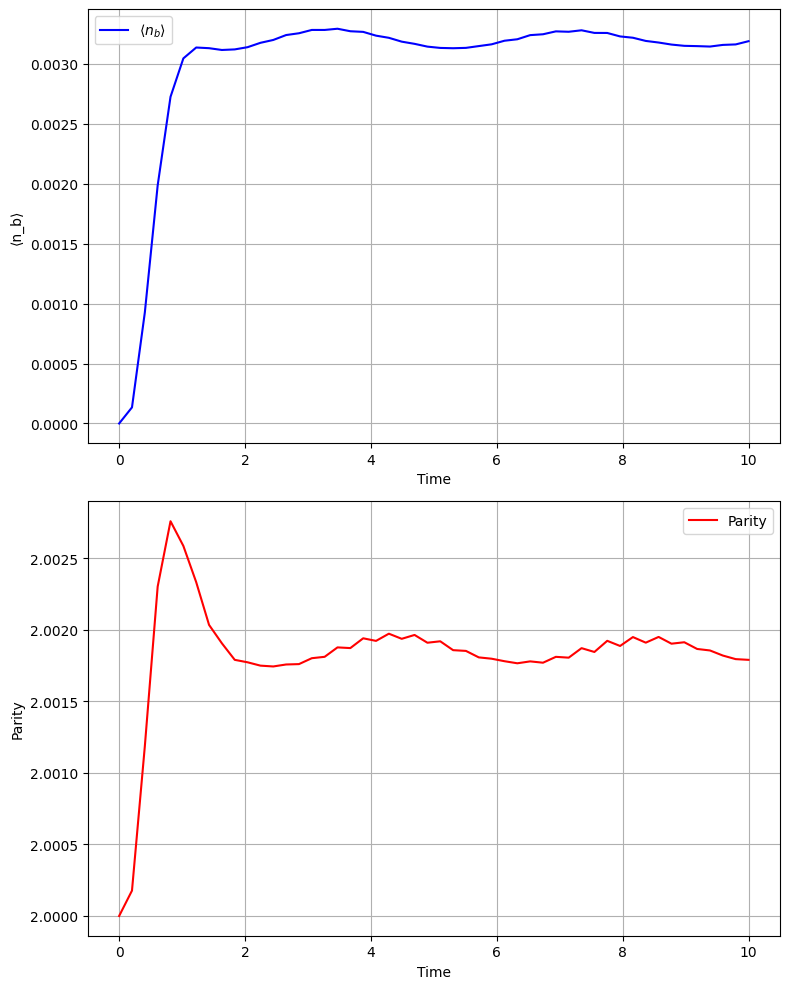

In [1]:
# Part a

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display
from scipy.linalg import expm, sinm, cosm
import dynamiqs as dq
from functools import reduce
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam

import dynamiqs as dq
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Hilbert-space truncations
na = 20   # Buffer mode a
nb = 5    # Memory mode b
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0 + 0j                      # Coherent drive applied to the buffer mode
kappa_b = 10                 # Decay rate of the buffer mode
alpha = 2

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Mode a annihilation operator
# a = dq.tensor(dq.destroy(na), dq.zeros(nb))     # Mode a annihilation operator
adag = a.dag()                                # Mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Mode b annihilation operator
# b = dq.tensor(dq.zeros(na), dq.destroy(nb))     # Mode b annihilation operato
bdag = b.dag()                                # Mode b creation operator

# Define the bosonic operator O = a† b
# O = adag @ a + bdag @ b - bdag @ b @ adag @ a - bdag @ bdag @ b @ b - adag @ adag @ a @ a
O = adag @ b

# Define the Hermitian Hamiltonian for the Zeno gate
epsilon_Z = 0.2 + 0j  # Choose an appropriate strength
# H_Z = jnp.conjugate(epsilon_Z) * O + epsilon_Z * O.dag()  # Ensures Hermiticity
# H_Z = jnp.conjugate(epsilon_Z) * a + epsilon_Z * a.dag()  # Ensures Hermiticity
H_Z = epsilon_Z * (adag + a)
# H_Z = adag @ a + bdag @ b - bdag @ b @ adag @ a - bdag @ bdag @ b @ b - adag @ adag @ a @ a
# H_Z = epsilon_Z * (expm(a @ bdag) + expm(adag @ b))

# Add other interaction Hamiltonians if required
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
H = H_2ph + H_d + H_Z
# H = jnp.conjugate(epsilon_Z) * O + epsilon_Z * O.dag() +  g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag) + jnp.conjugate(eps_d) * b + eps_d * bdag 
# H = H_Z
# Initialize to the |+⟩ state in the composite system (mode a and b)

cat_plus_a = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))  # Even cat state in mode a
cat_plus_b = dq.unit(dq.coherent(nb, alpha) + dq.coherent(nb, -alpha))
cat_minus_a = dq.unit(dq.coherent(na, alpha) - dq.coherent(na, -alpha))  # Even cat state in mode a
cat_minus_b = dq.unit(dq.coherent(nb, alpha) - dq.coherent(nb, -alpha))
psi0 = dq.tensor(cat_plus_a, dq.fock(nb, 0))  # |+⟩ state for mode a, vacuum for mode b
# psi0 = dq.tensor(cat_plus_a, cat_plus_b)
# psi0 = dq.tensor(cat_minus_a, cat_minus_b)

# Create time array
T = 10  # Simulation time
t_save = np.linspace(0, T, 50)

# Collapse operators (optional)
c_ops = [jnp.sqrt(kappa_b) * b]     # Some decay on mode b
# c_ops = [0 * b]

# Solve the Lindblad equation
res = dq.mesolve(H, c_ops, psi0, t_save)

# -------------------------------
# 10. Create the GIF: Compute the Wigner function of the memory mode (by tracing out the buffer)
# -------------------------------
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))
def update(frame):
    ax_w.cla()  # Clear previous frame
    # Extract the reduced density matrix for the memory mode:
    rho_a = dq.ptrace(res.states[frame], 0)
    # Plot the Wigner function for the memory mode:
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Memory Mode Wigner Function\nTime = {t_save[frame]:.2f}")

ani = FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_memory_mode_Zeno.gif'
ani.save(gif_filename, writer=PillowWriter(fps=50))

plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))



# Check evolution by plotting expectation values of photon number and parity in mode b
n_b = bdag @ b
# Build the parity operator for mode b
parity_b_local = dq.zeros(nb)  # Initialize zero matrix in mode b
for n in range(nb):
    parity_b_local = parity_b_local.addscalar((-1)**n) + dq.fock_dm(nb, n)

# Now, tensor with the identity for mode a.
parity_b = dq.tensor(dq.eye(na), parity_b_local)


n_b_expect = [dq.expect(n_b, state) for state in res.states]
parity_b_expect = [dq.expect(parity_b, state) for state in res.states]

# Plot the expectation value and parity for mode b
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the expectation value of the photon number in mode b.
ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_b⟩')
ax1.legend()
ax1.grid(True)

# Plot the photon number parity in mode b.
ax2.plot(t_save, parity_b_expect, label='Parity', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


